# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [ ]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [ ]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [ ]:
data.keys()

dict_keys(['items', 'found', 'pages', 'per_page', 'page', 'clusters', 'arguments', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [ ]:
from time import sleep
job_names = ['нейрохирург', 'ML инженер', 'бариста', 'дворник', 'энергетик']

params = {
    'area': 1,
    'per_page': 100
}

res = []
for job in job_names:
    cnt=0
    recieved = 0
    page = 0
    params['text'] = job
    print(job)
    while recieved == 100 or page == 0:
        params['page'] = page
        data = requests.get(URL, params).json()
        recieved = len(data['items'])
        cnt += recieved
        res.extend(data['items'])
        sleep(0.01)
        page += 1
    print(cnt)
        

нейрохирург
75
ML инженер
223
бариста
1069
дворник
1790
энергетик
1376


(1 балл) Посчитайте сколько всего найдено вакансий:

In [ ]:
print(len(res))

4533


(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [ ]:
from math import sin,cos,atan2,sqrt, pi
class coordinats:
    lat: float
    lng: float
    def __init__(self, lat, lng):
        self.lat = lat
        self.lng = lng

    def dist(self, other):
        R = 6373.0
        coef = pi/180
        dlng = (other.lng - self.lng) * coef
        dlat = (other.lat - self.lat) * coef
        a = sin(dlat / 2)**2 + cos(self.lat * coef) * cos(other.lat * coef) * sin(dlng / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c

class Company:
    name: str
    coords:coordinats
    def __init__(self,name, coords):
        self.name = name
        self.coords = coords
    


(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [ ]:
companies=[]
for job in res:
    name = None
    coords = None
    if(job['address'] != None):
        lat = job['address']['lat']
        lng = job['address']['lng']
        coords = coordinats(lat,lng)
    if(job['employer'] != None):
        name = job['employer']['name']
    c = Company(name,coords)
    companies.append(c)


(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [ ]:
coordinated = [comp for comp in companies if comp.coords is not None]
print(len(coordinated))

3528


(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [ ]:
center = coordinats(55.752412,37.623144)

r = 25

companies_in_mkad = [company for company in coordinated 
                        if company.coords.lng is not None 
                            and abs(center.dist(company.coords)) < r]
print(len(companies_in_mkad))

3123


(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

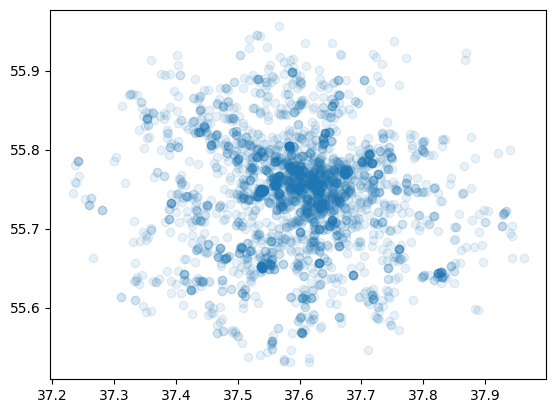

In [ ]:
# import matplotlib.pyplot as plt
y = [comp.coords.lat for comp in companies_in_mkad]
x = [comp.coords.lng for comp in companies_in_mkad]
plt.scatter(x=x, y=y,alpha=0.1)
plt.show()

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве): 

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ValueError: ignored

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

В центре выше плотность вакансий

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [ ]:
!gdown 1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU

Downloading...
From: https://drive.google.com/uc?id=1uIWeZFz3ElB5p1brBVEwJBHTbjXNPdfU
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 45.5MB/s]


Создадим DataFrame:

In [ ]:
diamonds = pd.read_csv("diamonds.csv")

(0.5 балла) Выведете первые 5 строк датасета:

In [ ]:
diamonds.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,None,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,None,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,None,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [ ]:
len(diamonds)

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [ ]:
f"{diamonds['total_sales_price'].idxmax()} - {diamonds['total_sales_price'].max()}"

'219702 - 1449881'

(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [ ]:
((diamonds == 'unknown' )| (diamonds == 'None')).sum().sum()


1891168

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [ ]:
list(diamonds.columns[((diamonds == 'unknown') | (diamonds=='None')).sum() != 0])

['color',
 'cut_quality',
 'eye_clean',
 'culet_size',
 'culet_condition',
 'girdle_min',
 'girdle_max',
 'fluor_color',
 'fluor_intensity',
 'fancy_color_dominant_color',
 'fancy_color_secondary_color',
 'fancy_color_overtone',
 'fancy_color_intensity']

В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными. 

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [ ]:
cols = list(filter(lambda s: s.startswith(('fancy_color_','fluor_')),diamonds.columns))
cols

['fluor_color',
 'fluor_intensity',
 'fancy_color_dominant_color',
 'fancy_color_secondary_color',
 'fancy_color_overtone',
 'fancy_color_intensity']

2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках: 

In [ ]:
((diamonds[cols] == 'unknown' )| (diamonds[cols] == 'None')).sum()

fluor_color                    203977
fluor_intensity                143619
fancy_color_dominant_color     210539
fancy_color_secondary_color    218641
fancy_color_overtone           219315
fancy_color_intensity          210541
dtype: int64

3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [ ]:
diamonds = diamonds.drop(cols,axis=1)

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [ ]:
cols = list(filter(lambda s: s.startswith(('culet_')),diamonds.columns))
diamonds = diamonds.drop(cols, axis = 1)

(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [ ]:
f"{round(diamonds['total_sales_price'].sum() / 1000)} thousands bucks"

'1517722 thousands bucks'

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [ ]:
diamonds[::2]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [ ]:
diamonds[::6]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [ ]:
list(diamonds.dtypes[diamonds.dtypes == object].index)

['cut',
 'color',
 'clarity',
 'cut_quality',
 'lab',
 'symmetry',
 'polish',
 'eye_clean',
 'girdle_min',
 'girdle_max']

>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [ ]:
# your code here

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

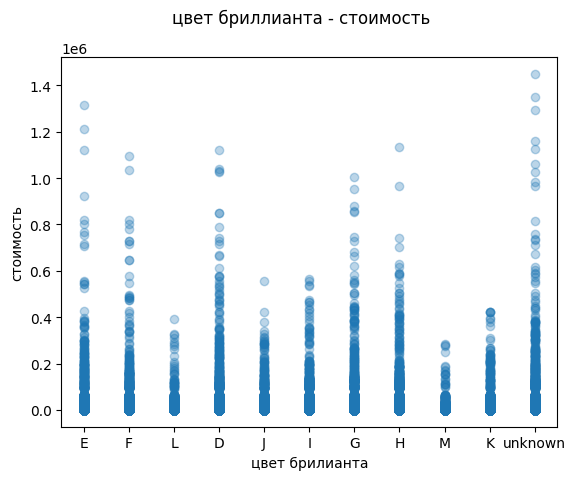

In [ ]:
plt.scatter(diamonds['color'],diamonds['total_sales_price'],alpha=0.3)
plt.suptitle('цвет бриллианта - стоимость')
plt.xlabel('цвет брилианта')
plt.ylabel('стоимость')
plt.show()

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

<Axes: xlabel='лабараторная оценка', ylabel='кол-во бриллиантов'>

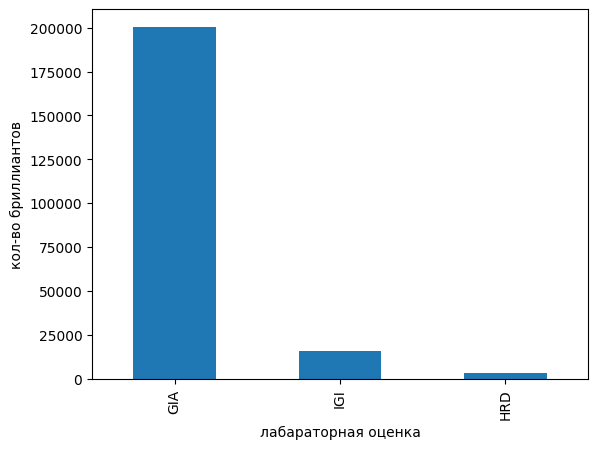

In [ ]:
diamonds['lab'].value_counts().plot(kind='bar',xlabel='лабараторная оценка',ylabel='кол-во бриллиантов')


(2 балла) Постройте график `вес бриллианта - стоимость`:

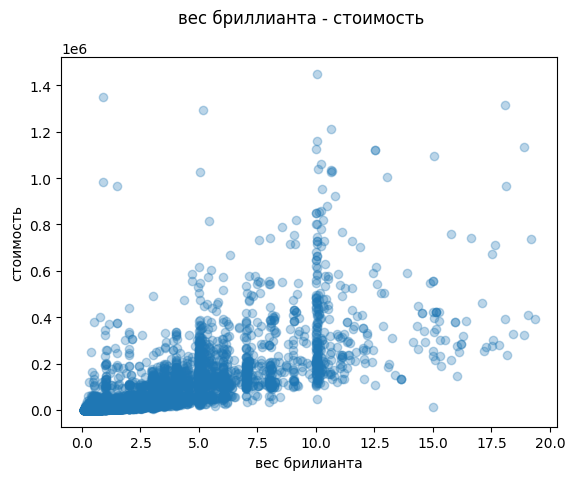

In [ ]:
plt.scatter(diamonds['carat_weight'],diamonds['total_sales_price'],alpha=0.3)
plt.suptitle('вес бриллианта - стоимость')
plt.xlabel('вес брилианта')
plt.ylabel('стоимость')
plt.show()

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

<Axes: xlabel='система оценки GIA Cut', ylabel='кол-во бриллиантов'>

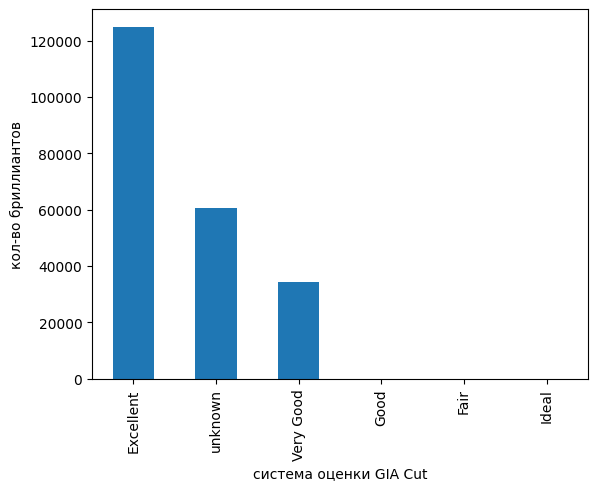

In [ ]:
diamonds['cut_quality'].value_counts().plot(kind='bar',xlabel='система оценки GIA Cut',ylabel='кол-во бриллиантов')


(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

самый дорогой бриллиант с известным цветом имеет цвет E<br>
Больше всего бриилиантов с лабораторной оценкой GIA<br>
Больше всего бриллиантов c оценкой Excellent

## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно: 
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк: 

In [ ]:
df = diamonds[["meas_length","meas_width","meas_depth","total_sales_price"]]
df.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом: 

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,meas_length,meas_width,meas_depth,total_sales_price
0,4.95,5.00,3.18,2304
1,8.99,5.62,3.52,5933
2,7.93,4.15,2.39,1176
3,8.66,8.70,5.29,21420
4,5.13,5.18,3.24,3902


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [ ]:
def mink_sum(df):
  x = df.meas_length
  y = df.meas_width
  z = df.meas_depth
  return (abs(x - y) ** 3 + abs(y - z) ** 3 + abs(z - x) ** 3) ** (1/3)
df["mink_sum"] = df.apply(mink_sum, axis=1)
df.head()

,meas_length,meas_width,meas_depth,total_sales_price,mink_sum
0,4.95,5.00,3.18,2304,2.262005
1,8.99,5.62,3.52,5933,5.955232
2,7.93,4.15,2.39,1176,6.122424
3,8.66,8.70,5.29,21420,4.271282
4,5.13,5.18,3.24,3902,2.413167


(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`: 

In [ ]:
df2 = df[['mink_sum','total_sales_price']]
df2.head()

,mink_sum,total_sales_price
0,2.262005,2304
1,5.955232,5933
2,6.122424,1176
3,4.271282,21420
4,2.413167,3902


(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df2,test_size=0.2)

(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

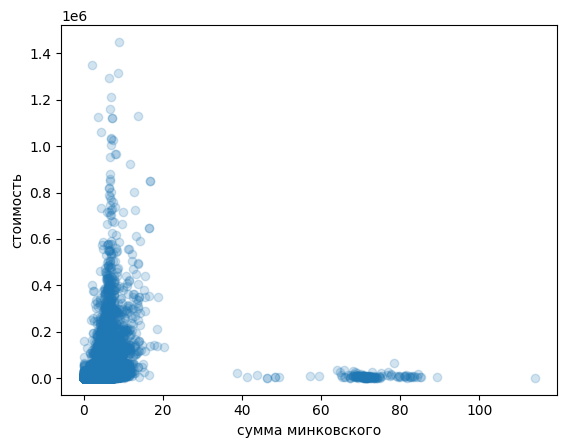

In [ ]:
train_x, train_y = train['mink_sum'], train['total_sales_price']

plt.scatter(train_x,train_y,alpha=.2)
plt.xlabel('сумма минковского')
plt.ylabel('стоимость')
plt.show()

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

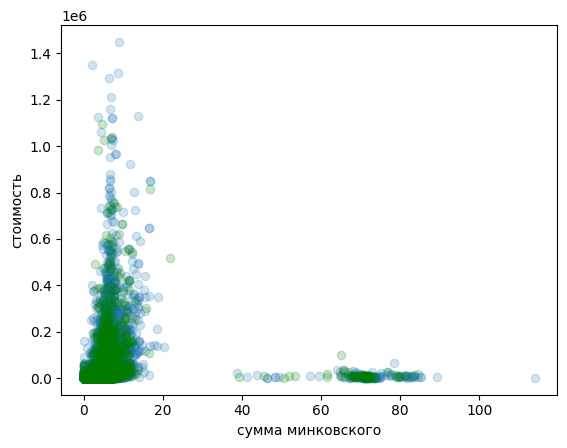

In [ ]:
test_x, test_y = test['mink_sum'], test['total_sales_price']
plt.scatter(train_x,train_y,alpha=.2)
plt.scatter(test_x,test_y,c='green',alpha=.2)
plt.xlabel('сумма минковского')
plt.ylabel('стоимость')
plt.show()

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [ ]:
from scipy.spatial import KDTree
tree = KDTree(train[['total_sales_price', 'mink_sum']])
distances, indexes = tree.query(test[['total_sales_price', 'mink_sum']], k=1)  
test["nearest_dist"] = distances
test["nearest_index"] = indexes
train

,mink_sum,total_sales_price
147331,2.255330,1680
135591,2.078947,1018
152620,2.898040,8444
207981,2.191434,15453
35913,4.535828,828
...,...,...
50026,3.052877,3091
19704,4.546858,23712
55196,3.056386,5116
121502,2.211325,2506


(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [ ]:
def price_diff(df):
  price_test = df.total_sales_price
  nearest_ind = df.nearest_index
  price_train = train.loc[nearest_ind].total_sales_price
  return str(round((price_test - price_train) / price_train * 100, 1)) + "%"
test["price_diff"] = test.apply(price_diff, axis=1)
test.head()

KeyError: ignored

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [ ]:
from sklearn.preprocessing import OneHotEncoder
X,y = diamonds[['cut_quality','lab']], diamonds['total_sales_price']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
X = pd.DataFrame(enc.transform(X).toarray())

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=57)
model.fit(X_train, y_train)
print('fitted')

fitted


(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [ ]:
from sklearn.metrics import mean_squared_error
y_predicted = model.predict(X_test)
mean_squared_error(y_test,y_predicted)

658452587.981615

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)